In [2]:
import glob
import numpy as np
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [3]:
MIDI_PATH = "./midi_songs/*.mid"
SEQUENCE_LENGTH = 100
EPOCHS = 100
BATCH_SIZE = 128

In [4]:
def get_notes():
    notes = []
    for file in glob.glob(MIDI_PATH):
        midi = converter.parse(file)
        parts = instrument.partitionByInstrument(midi)
        
        if parts:
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
                
    return notes

def prepare_sequences(notes):
    pitchnames = sorted(set(notes))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    network_input = []
    network_output = []
    
    for i in range(0, len(notes) - SEQUENCE_LENGTH):
        sequence_in = notes[i:i + SEQUENCE_LENGTH]
        sequence_out = notes[i + SEQUENCE_LENGTH]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])
    
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, SEQUENCE_LENGTH, 1))
    network_input = network_input / float(len(pitchnames))
    network_output = tf.keras.utils.to_categorical(network_output)
    
    return network_input, network_output, len(pitchnames)

In [9]:
def create_model(n_vocab):
    model = Sequential()
    
    model.add(LSTM(512, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(LSTM(512, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(LSTM(512))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(n_vocab, activation='softmax'))
    
    # Compile the model with both loss and accuracy metrics
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy',  # Use appropriate loss based on your output
        metrics=['accuracy']             # Include accuracy as a metric
    )
    return model

# Get training data
notes = get_notes()
network_input, network_output, n_vocab = prepare_sequences(notes)

# Create model
model = create_model(n_vocab)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │        41,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,430,688 (20.72 MB)

 Trainable params: 5,427,104 (20.70 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [10]:
"""
Train the neural network for generating music sequences.

This training setup adjusts model weights using robust callbacks to monitor 
both loss and accuracy, dynamically adjust the learning rate, and save the best 
model. The focus is on minimizing loss and maximizing accuracy.
"""

# Define callbacks for efficient and robust training
callbacks = [
    # Save the best model based on the lowest loss
    ModelCheckpoint(
        filepath='best_lstm_music_model.keras',  # Save path for the best model
        monitor='loss',                          # Monitor training loss
        save_best_only=True,                     # Save only when loss improves
        mode='min',                              # Minimize the loss
        verbose=1                                # Show checkpointing details
    ),
    # Dynamically reduce learning rate when training stagnates
    ReduceLROnPlateau(
        monitor='loss', 
        factor=0.5,                              # Halve the learning rate
        patience=5,                              # Wait for 5 epochs with no improvement
        min_lr=1e-6,                             # Set a floor for the learning rate
        verbose=1                                # Log learning rate adjustments
    ),
    # Stop training early if no improvement is observed
    EarlyStopping(
        monitor='loss', 
        patience=10,                             # Wait for 10 epochs of no improvement
        restore_best_weights=True,              # Load the best weights on stop
        verbose=1                                # Show early stopping details
    )
]

# Train the model
history = model.fit(
    network_input,    # Input data (normalized sequences)
    network_output,   # Output data (target sequences)
    epochs=EPOCHS,       # Number of epochs to train
    batch_size=BATCH_SIZE,   # Size of each training batch
    callbacks=callbacks,  # Attach the robust callbacks
    verbose=1,        # Show detailed training progress
    validation_split=0.2  # Split 20% of data for validation
)

# Save final model
model.save('final_model.keras')

# Print training results
print("Training complete! The best model has been saved as 'final_model.keras'.")


Epoch 1/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0173 - loss: 5.5701
Epoch 1: loss improved from inf to 5.37509, saving model to best_lstm_music_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.0175 - loss: 5.5624 - val_accuracy: 0.0548 - val_loss: 4.6793 - learning_rate: 0.0010
Epoch 2/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0402 - loss: 4.9135
Epoch 2: loss improved from 5.37509 to 4.83791, saving model to best_lstm_music_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0403 - loss: 4.9105 - val_accuracy: 0.0271 - val_loss: 4.7348 - learning_rate: 0.0010
Epoch 3/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0471 - loss: 4.6487
Epoch 3: loss improved from 4.83791 to 4.66762, saving model to best_lstm_music_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0471 - loss: 4.6495 - val_accuracy: 0.0434 - val_loss: 4.6293 - learning_rate: 0.0010
Epoch 4/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/ste

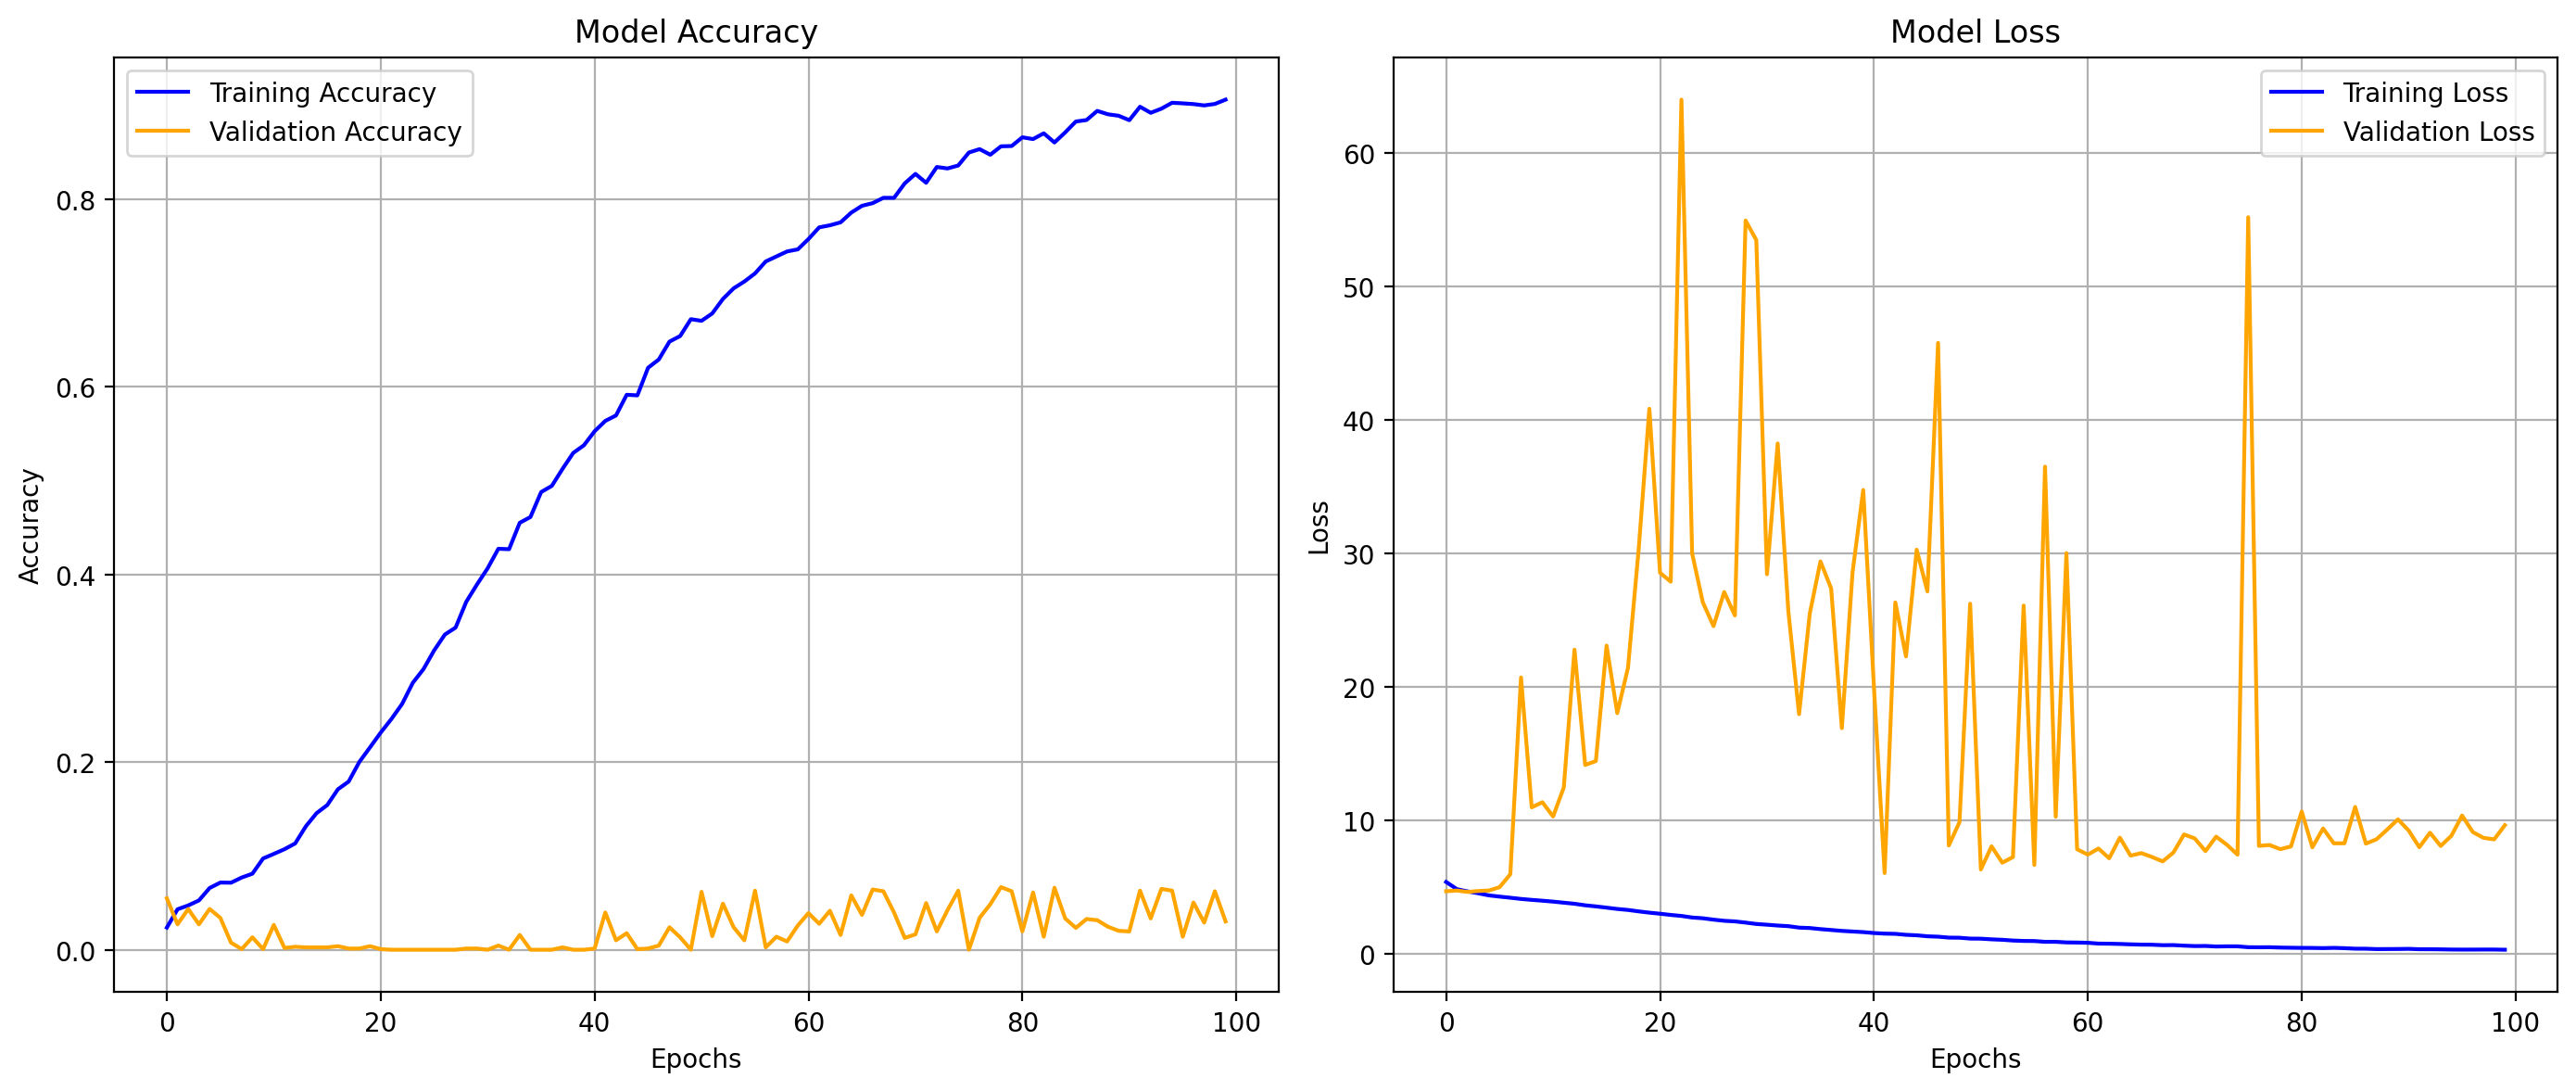

In [11]:
# Plot training accuracy and loss
def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Call the function to visualize the training history
plot_training_history(history)